<a href="https://colab.research.google.com/github/sourcecode369/unconventional-neural-networks/blob/master/image-colorization/Black_and_White_Image_Colorization_using_Autoencoders_and_InceptionResnetv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rhtsingh","key":"694681130c8b848aaca6d1d52f6b594d"}'}

In [0]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 2.5MB/s 
     |████████████████████████████████| 5.3MB 8.2MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 112kB 55.9MB/s 
     |████████████████████████████████| 112kB 60.5MB/s 


In [5]:
!ls ~/.kaggle

kaggle.json


In [6]:
!kaggle datasets list

ref                                                      title                                               size  lastUpdated          downloadCount  
-------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
rajeevw/ufcdata                                          UFC-Fight historical data from 1993 to 2019          3MB  2019-07-05 09:58:02           9925  
gustavomodelli/forest-fires-in-brazil                    Forest Fires in Brazil                              31KB  2019-08-24 16:09:16          15349  
akhilv11/border-crossing-entry-data                      Border Crossing Entry Data                           4MB  2019-08-21 14:51:34           6385  
tristan581/17k-apple-app-store-strategy-games            17K Mobile Strategy Games                            8MB  2019-08-26 08:22:16          12889  
chirin/africa-economic-banking-and-systemic-crisis-data  Africa Economic, Banking and Sy

In [49]:
!kaggle datasets download -d thedownhill/art-images-drawings-painting-sculpture-engraving
!kaggle datasets download -d valkling/inception-resnet-v2-weights

 90% 178M/199M [00:07<00:00, 22.7MB/s]
100% 199M/199M [00:07<00:00, 29.0MB/s]


In [0]:
import os
import sys
import random
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=UserWarning, module='skimage')

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from PIL import Image
from tqdm import tqdm
from itertools import chain 
from IPython.display import clear_output, display 

import skimage
from skimage.io import (imread, 
                        imshow, 
                        imread_collection, 
                        concatenate_images)
from skimage.transform import resize
from skimage.util import crop, pad
from skimage.morphology import label 
from skimage.color import (rgb2gray, 
                           gray2rgb, 
                           rgb2lab, 
                           lab2rgb)

from sklearn.model_selection import train_test_split

from keras.applications.inception_resnet_v2 import (InceptionResNetV2, 
                                                    preprocess_input, 
                                                    decode_predictions)
from keras.layers import (Input, Dense, 
                          UpSampling2D, 
                          RepeatVector, 
                          Reshape, Conv2D, 
                          Conv2DTranspose, 
                          MaxPool2D, 
                          MaxPooling2D, 
                          Dropout, Lambda)
from keras.models import (Model, 
                          Sequential, 
                          load_model)
from keras.layers.merge import concatenate
from keras.preprocessing.image import ImageDataGenerator 
from keras.callbacks import (ModelCheckpoint, 
                             EarlyStopping, 
                             ReduceLROnPlateau, 
                             LearningRateScheduler)
from keras import backend as K
import tensorflow as tf
np.random.seed(2019)
random.seed(2019)

In [50]:
!ls -GFlash --color

total 782M
4.0K drwxr-xr-x 1 root 4.0K Nov 24 18:56 ./
4.0K drwxr-xr-x 1 root 4.0K Nov 24 14:41 ../
4.0K drwxr-xr-x 4 root 4.0K Nov 24 15:54 art-images-drawings-painting-sculpture-engraving/
583M -rw-r--r-- 1 root 583M Nov 24 14:45 art-images-drawings-painting-sculpture-engraving.zip
4.0K drwxr-xr-x 1 root 4.0K Nov 21 16:30 .config/
199M -rw-r--r-- 1 root 199M Nov 24 18:56 inception-resnet-v2-weights.zip
4.0K drwxr-xr-x 1 root 4.0K Nov 21 16:30 sample_data/


In [0]:
import zipfile
with zipfile.ZipFile('art-images-drawings-painting-sculpture-engraving.zip', 'r') as zip_ref:
    zip_ref.extractall('art-images-drawings-painting-sculpture-engraving')

with zipfile.ZipFile('inception-resnet-v2-weights.zip', 'r') as zip_ref:
    zip_ref.extractall()


In [52]:
!ls 

art-images-drawings-painting-sculpture-engraving
art-images-drawings-painting-sculpture-engraving.zip
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5
inception-resnet-v2-weights.zip
sample_data


### Read in data

In [35]:
for _, __, filename in os.walk('art-images-drawings-painting-sculpture-engraving/dataset/dataset_updated/training_set/'):
  if len(filename)!=0:
    print(len(filename),":",filename)

1745 : ['i - 230.jpeg', 'i - 940.jpeg', 'i - 1327.jpeg', 'i - 25.jpeg', '130.jpg', 'i - 632.jpeg', 'i - 1442.jpeg', 'i - 1321.jpeg', 'i - 825.jpeg', '293.jpg', 'i - 329 20.26.47.jpeg', 'i - 18.jpeg', 'i - 644.jpeg', 'i - 1174.jpeg', 'i - 459.jpeg', 'i - 703.jpeg', '58.jpg', 'i - 643.jpeg', 'i - 1000.jpeg', '227.jpg', 'i - 834.jpeg', 'i - 690.jpeg', 'i - 446.jpeg', 'i - 39.jpeg', 'i - 277.jpeg', 'i - 358.jpeg', 'i - 948.jpeg', 'i - 350.jpeg', 'i - 80.jpeg', 'i - 1384.jpeg', 'i - 24.jpeg', 'i - 828.jpeg', 'i - 683.jpeg', 'i - 1264.jpeg', 'i - 22.jpeg', 'i - 816.jpeg', 'i - 706.jpeg', '5.jpg', 'i - 98.jpeg', 'i - 380.jpeg', 'i - 9.jpeg', '143.jpg', 'i - 353.jpeg', 'i - 154.jpeg', '3 18.59.45.jpg', 'i - 746.jpeg', 'i - 897.jpeg', 'i - 1101.jpeg', '220.jpg', 'i - 681.jpeg', 'i - 136.jpeg', 'i - 625.jpeg', '6006_mainfoto_05.jpg', 'i - 265.jpeg', 'i - 1273.jpeg', '53 18.59.45.jpg', '162.jpg', 'i - 805.jpeg', 'i - 1333.jpeg', 'i - 598.jpeg', '166.jpg', 'i - 536.jpeg', 'i - 929.jpeg', 'i - 1095

In [0]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = 'art-images-drawings-painting-sculpture-engraving/dataset/dataset_updated/training_set/painting/'
train_ids = next(os.walk(TRAIN_PATH))[2]

In [42]:
%%time
# (Note that 86 of the train_ids have errors while being loading into our dataset, so we will just skip over them. We don't really need them.)

X_train = np.zeros((len(train_ids)-86, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
missing_count = 0
print("Getting train images..")
sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
  path = TRAIN_PATH + id_ + ''
  try:
    img = imread(path)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n-missing_count] = img
  except:
    missing_count += 1

X_train = X_train.astype('float32') / 255.
print('Total missing: {}'.format(missing_count))

Getting train images..


100%|██████████| 2128/2128 [00:38<00:00, 54.57it/s]


Total missing: 86
CPU times: user 40.7 s, sys: 32.8 s, total: 1min 13s
Wall time: 40 s


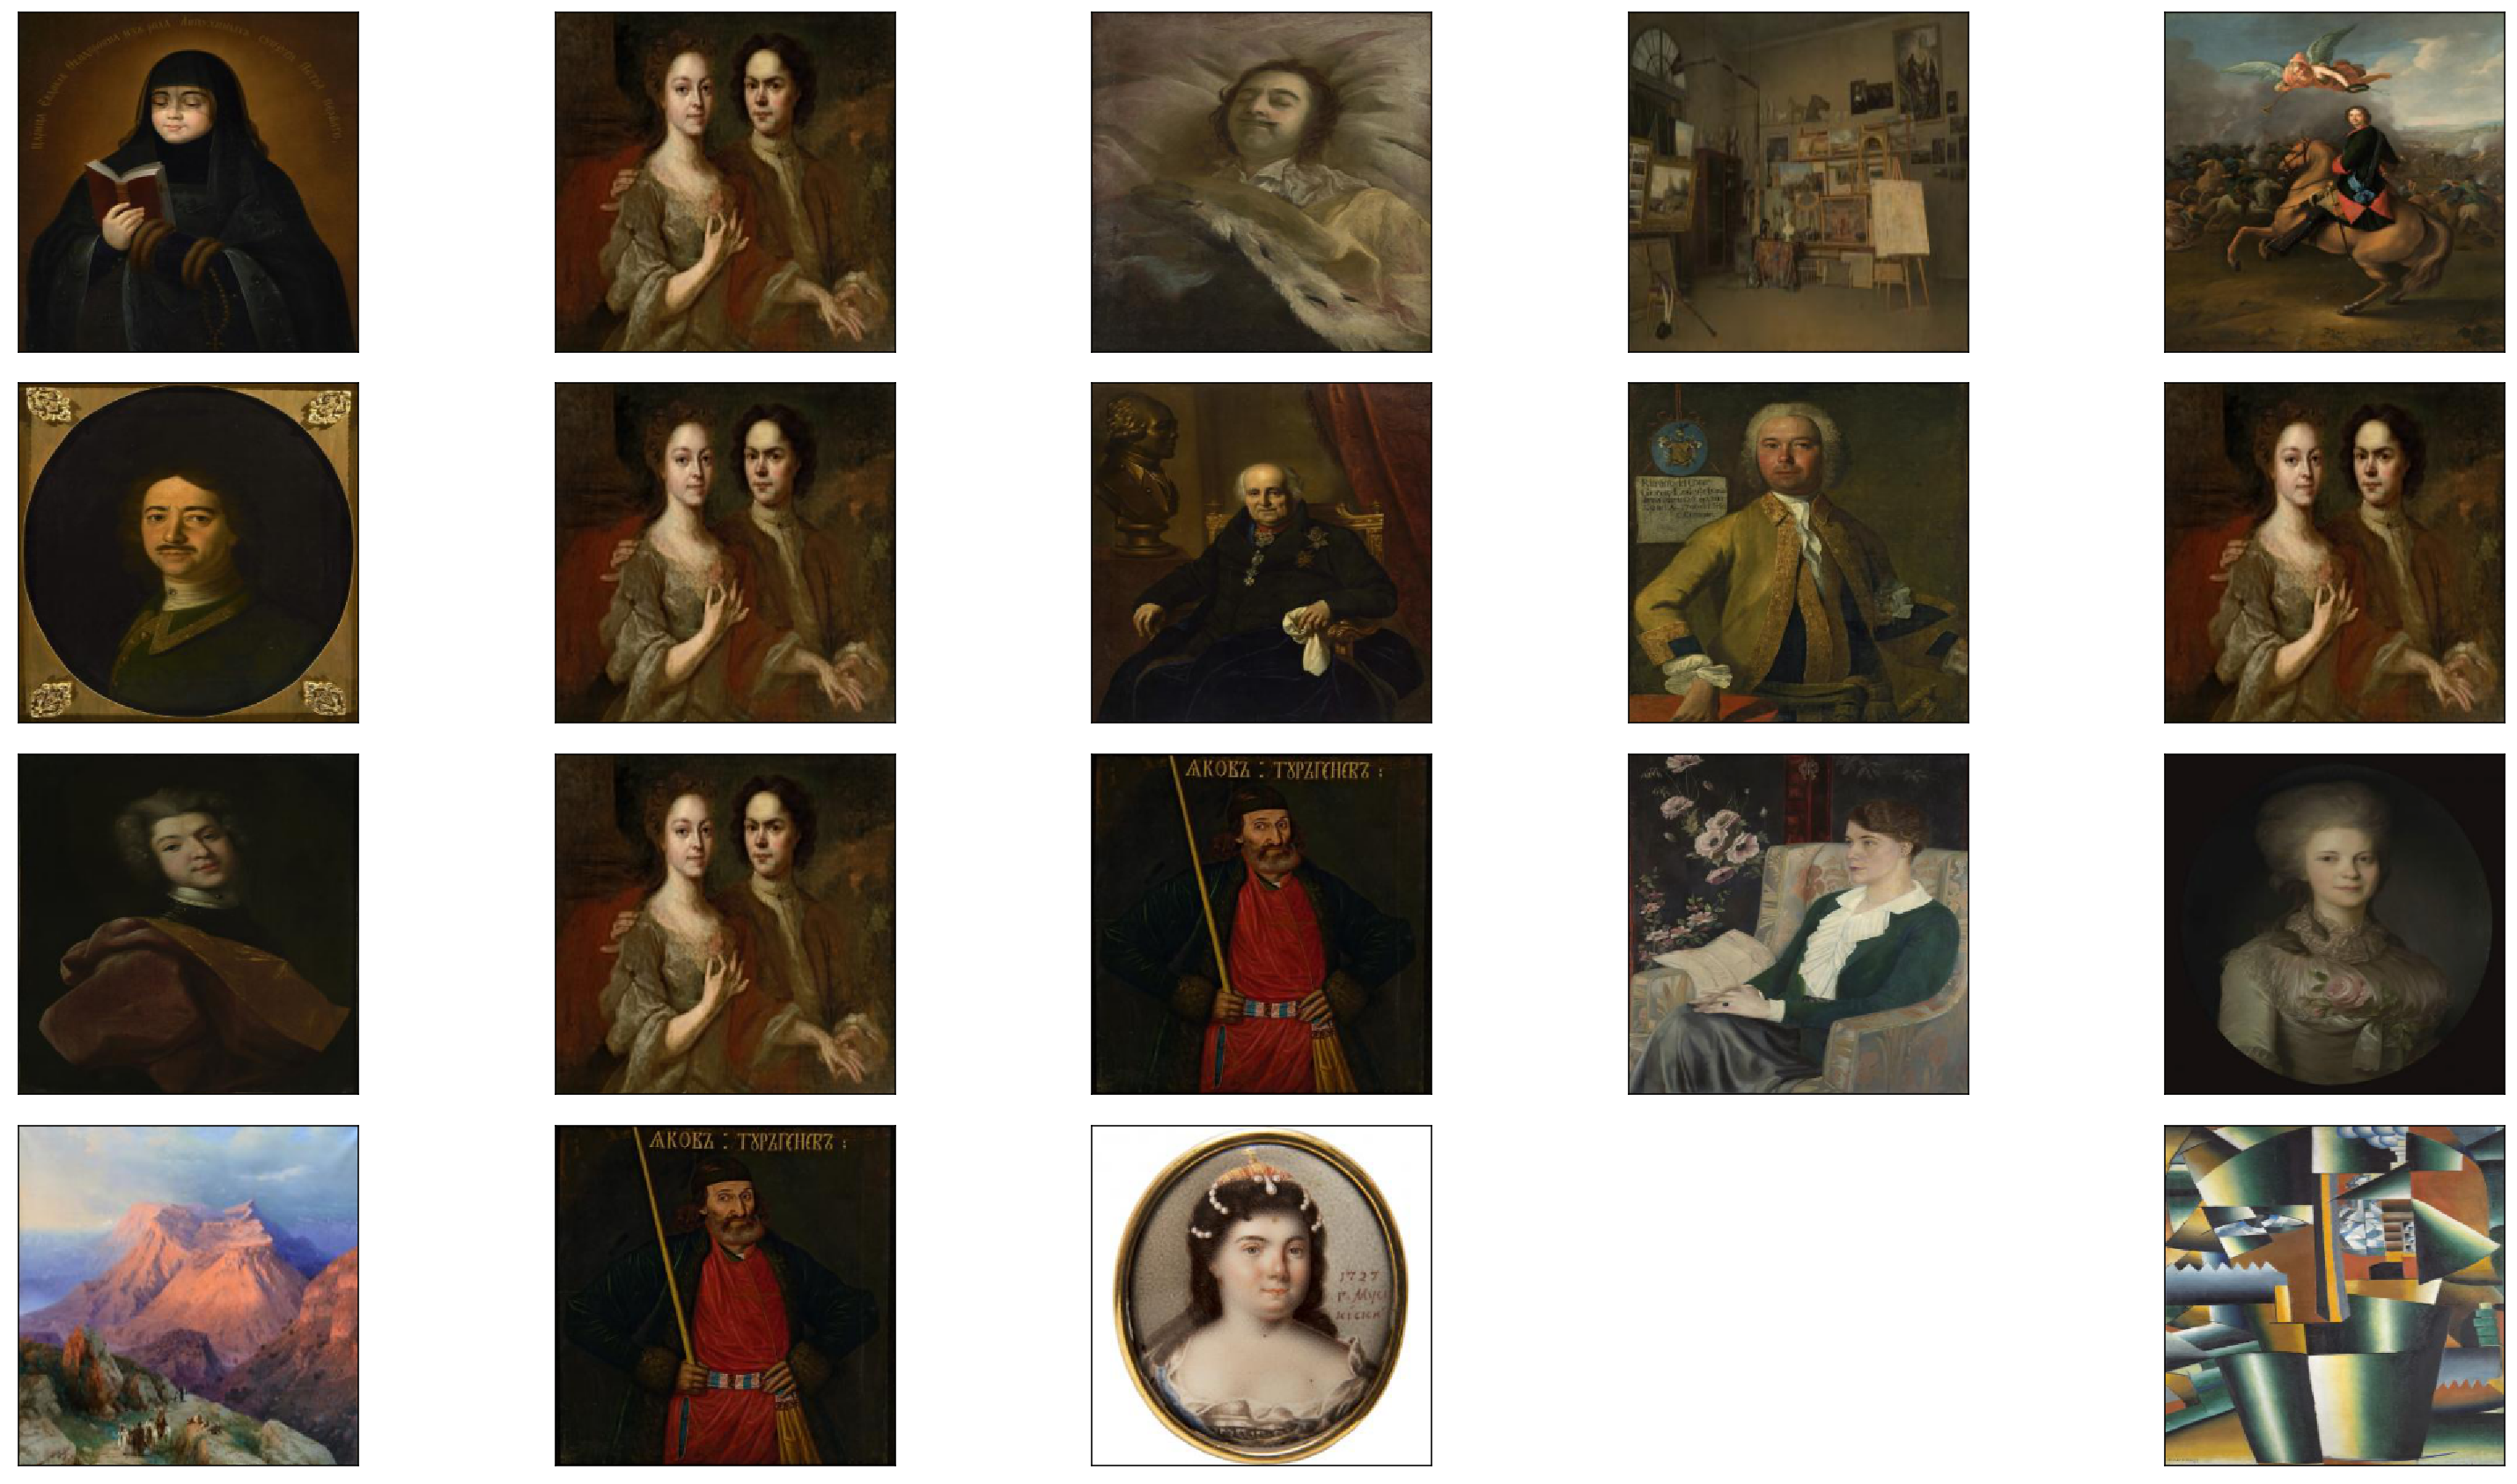

In [46]:
plt.figure(figsize=(22,12))
for i in range(20):
  plt.subplot(4,5,i+1)
  imshow(X_train[i])
  plt.xticks([])
  plt.yticks([])

In [0]:
X_train, X_test = train_test_split(X_train, test_size=20, random_state=2019)

### Create the model

In [61]:
def Colorize():
    embed_input = Input(shape=(1000,))
    
    #Encoder
    encoder_input = Input(shape=(256, 256, 1,))
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same',strides=1)(encoder_input)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(128, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same',strides=1)(encoder_output)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(256, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same',strides=1)(encoder_output)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(256, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
    
    #Fusion
    fusion_output = RepeatVector(32 * 32)(embed_input) 
    fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
    fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
    fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output)
    
    #Decoder
    decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
    decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(64, (4,4), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(32, (2,2), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    return Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

model = Colorize()
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_220 (Conv2D)             (None, 256, 256, 128 1280        input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 128, 128, 128 0           conv2d_220[0][0]                 
__________________________________________________________________________________________________
conv2d_221 (Conv2D)             (None, 128, 128, 128 262272      max_pooling2d_8[0][0]            
____________________________________________________________________________________________

In [0]:
inception = InceptionResNetV2(weights=None, include_top=True)
inception.load_weights('inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5')
inception.graph = tf.get_default_graph()

### Data Generator Functions

In [63]:
%%time

# image transformer
datagen = ImageDataGenerator(
    shear_range = 0.2,
    zoom_range = 0.2,
    rotation_range = 20,
    horizontal_flip = True
)

# create embedding
def create_inception_embedding(grayscaled_rgb):
  def resize_gray(x):
    return resize(x, (299,299,3), mode='constant')
  grayscaled_rgb_resized = np.array([resize_gray(x) for x in grayscaled_rgb])
  grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
  with inception.graph.as_default():
    embed = inception.predict(grayscaled_rgb_resized)
  return embed

# generate training data
def image_a_b_gen(dataset=X_train, batch_size = 20):
  for batch in datagen.flow(dataset, batch_size=batch_size):
      X_batch = rgb2gray(batch)
      grayscaled_rgb = gray2rgb(X_batch)
      lab_batch = rgb2lab(batch)
      X_batch = lab_batch[:,:,:,0]
      X_batch = X_batch.reshape(X_batch.shape+(1,))
      Y_batch = lab_batch[:,:,:,1:] / 128
      yield [X_batch, create_inception_embedding(grayscaled_rgb)], Y_batch

CPU times: user 144 µs, sys: 37 µs, total: 181 µs
Wall time: 188 µs


In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor='loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
file_path = 'Art_Colorization_Model.h5'
checkpoint = ModelCheckpoint(file_path,
                             save_best_only=True,
                             monitor='loss',
                             mode='min',
                             verbose=1)
model_callbacks = [learning_rate_reduction, checkpoint]

In [65]:
%%time
BATCH_SIZE = 20
model_history = model.fit_generator(image_a_b_gen(X_train, BATCH_SIZE), epochs=30,
                    verbose=1, steps_per_epoch=X_train.shape[0]//BATCH_SIZE,
                    callbacks=model_callbacks)

Epoch 1/30
101/101 [==============================] - 204s 2s/step - loss: 0.0160

Epoch 00001: loss improved from inf to 0.01603, saving model to Art_Colorization_Model.h5
Epoch 2/30
101/101 [==============================] - 179s 2s/step - loss: 0.0049

Epoch 00002: loss improved from 0.01603 to 0.00497, saving model to Art_Colorization_Model.h5
Epoch 3/30
101/101 [==============================] - 186s 2s/step - loss: 0.0048

Epoch 00003: loss improved from 0.00497 to 0.00477, saving model to Art_Colorization_Model.h5
Epoch 4/30
101/101 [==============================] - 185s 2s/step - loss: 0.0047

Epoch 00004: loss improved from 0.00477 to 0.00466, saving model to Art_Colorization_Model.h5
Epoch 5/30
101/101 [==============================] - 187s 2s/step - loss: 0.0047

Epoch 00005: loss improved from 0.00466 to 0.00466, saving model to Art_Colorization_Model.h5
Epoch 6/30
101/101 [==============================] - 185s 2s/step - loss: 0.0045

Epoch 00006: loss improved from 0.00

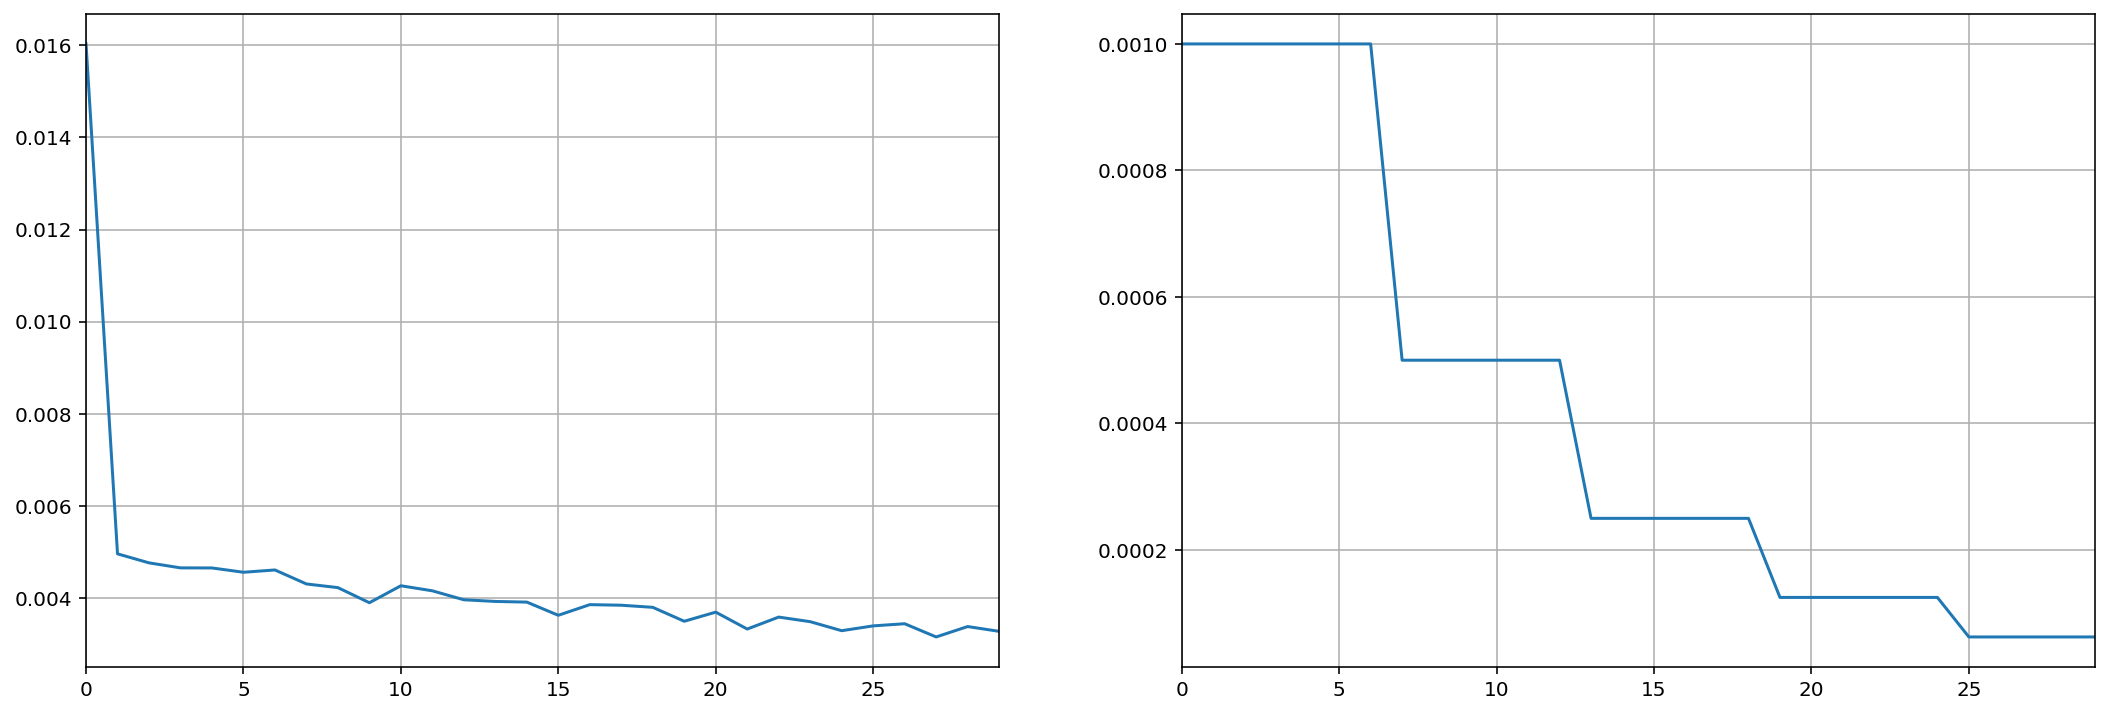

In [72]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
pd.DataFrame(model_history.history)["loss"].plot()
plt.grid(True)
plt.subplot(1,2,2)
pd.DataFrame(model_history.history)["lr"].plot()
plt.grid(True)

### Sample the results

In [0]:
sample = X_test 
color_me = gray2rgb(rgb2gray(sample))
color_me_embed = create_inception_embedding(color_me)
color_me = rgb2lab(color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape + (1,))

output = model.predict([color_me, color_me_embed])
output = output * 128

decoded_images = np.zeros((len(output), 256, 256, 3))
for i in range(len(output)):
  cur = np.zeros((256,256,3))
  cur[:,:,0] = color_me[i][:,:,0]
  cur[:,:,1:] = output[i]
  decoded_images[i] = lab2rgb(cur)
  cv2.imwrite("img_" + str(i) + ".jpg", lab2rgb(cur))

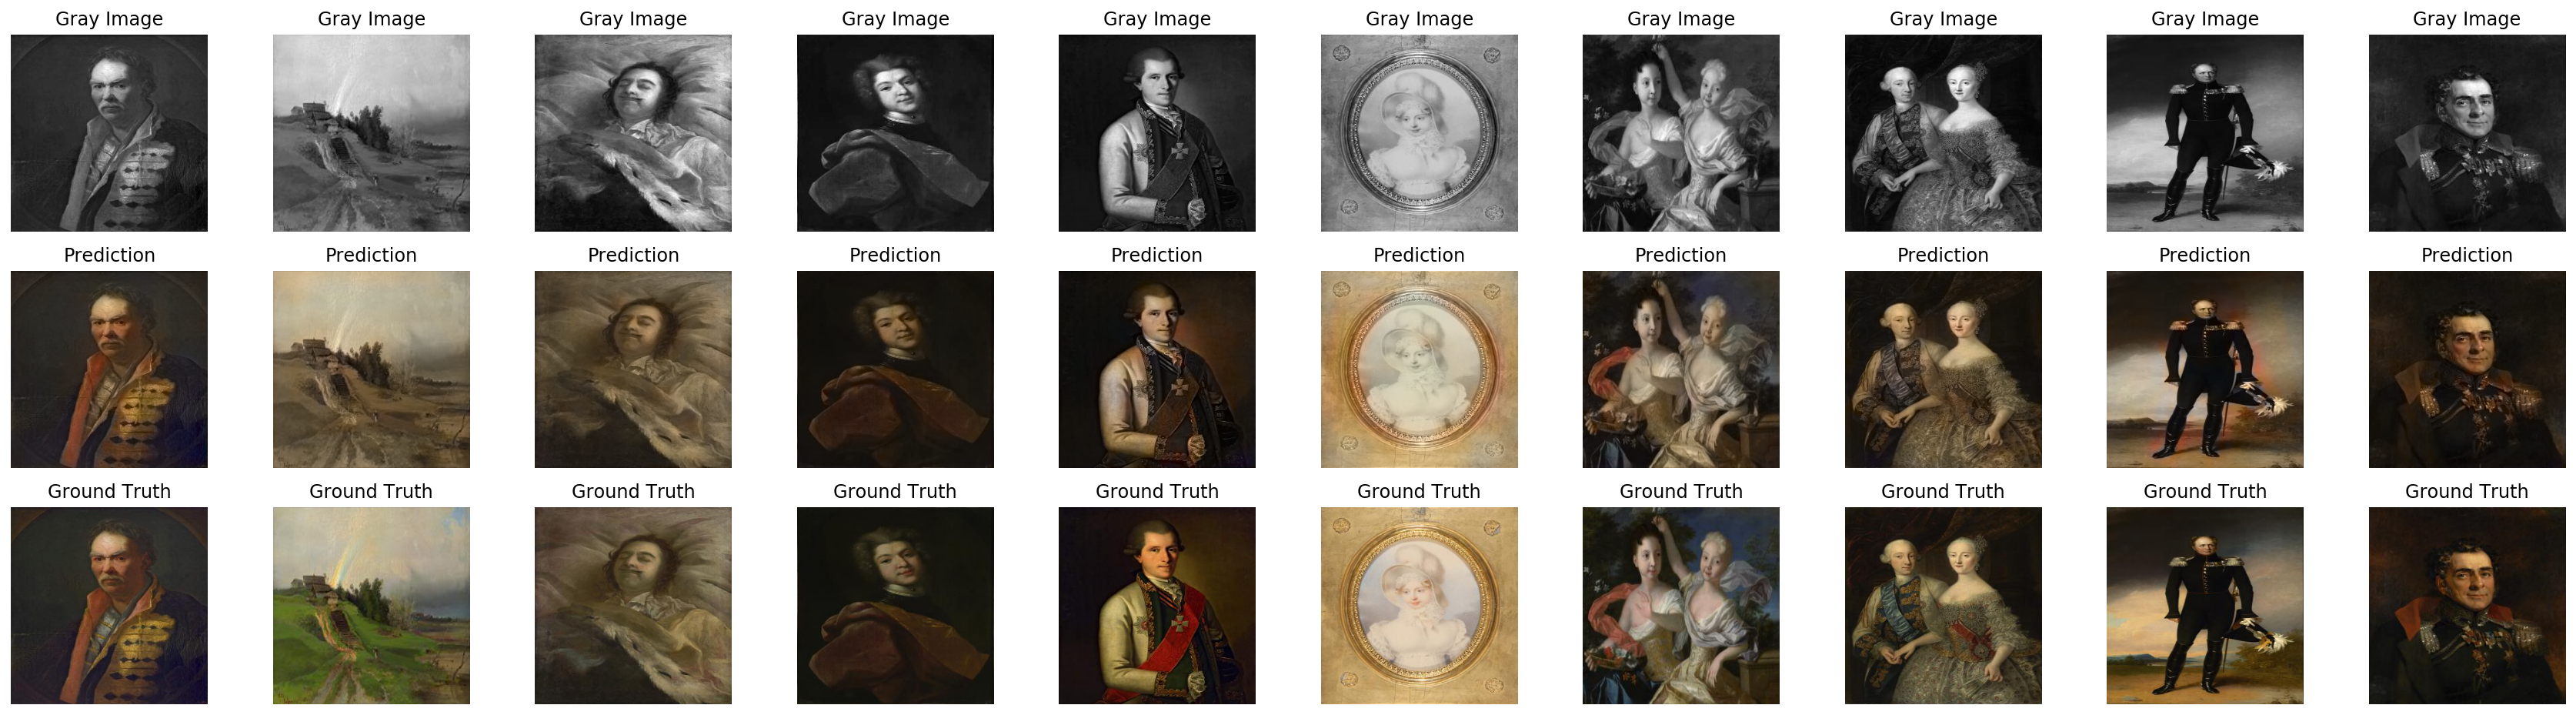

In [79]:
plt.figure(figsize=(30,8))
for i in range(10):
  plt.subplot(3,10,i+1)
  plt.imshow(rgb2gray(X_test)[i].reshape(256,256))
  plt.gray()
  plt.axis('off')
  plt.title("Gray Image")

  plt.subplot(3,10,i+1+10)
  plt.imshow(decoded_images[i].reshape(256, 256,3))
  plt.axis("off")
  plt.title("Prediction")

  plt.subplot(3,10,i+1+20)
  plt.imshow(X_test[i].reshape(256, 256,3))
  plt.axis("off")
  plt.title("Ground Truth")

### Santity Check

In [0]:
from keras.utils import get_file

(1, 256, 256, 3)


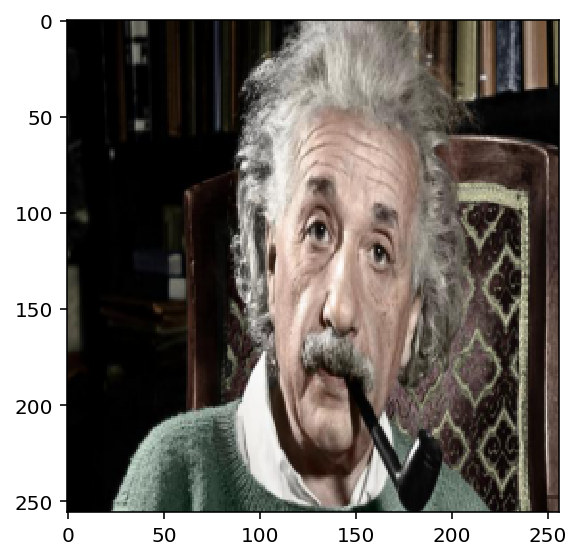

In [85]:
image_path = get_file("einstein.jpg","http://www.thetimes.co.uk/imageserver/image/methode%2Ftimes%2Fprod%2Fweb%2Fbin%2F66d3ff4e-f42e-11e9-aa63-3974183a04b4.jpg?crop=2278%2C1282%2C187%2C165&resize=685")
image = imread(image_path)
image = resize(image, (256,256))
imshow(image)
image = image[np.newaxis, ...]
print(image.shape)

In [0]:
color_me = gray2rgb(rgb2gray(image))
color_me_embed = create_inception_embedding(color_me)
color_me = rgb2lab(color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape + (1,))

output = model.predict([color_me, color_me_embed])
output = output * 128

decoded_images = np.zeros((len(output), 256, 256, 3))

In [0]:
for i in range(len(output)):
  cur = np.zeros((256,256,3))
  cur[:,:,0] = color_me[i][:,:,0]
  cur[:,:,1:] = output[i]
  decoded_images[i] = lab2rgb(cur)
  cv2.imwrite("img_" + str(i) + ".jpg", lab2rgb(cur))

Text(0.5, 1.0, 'Ground Truth')

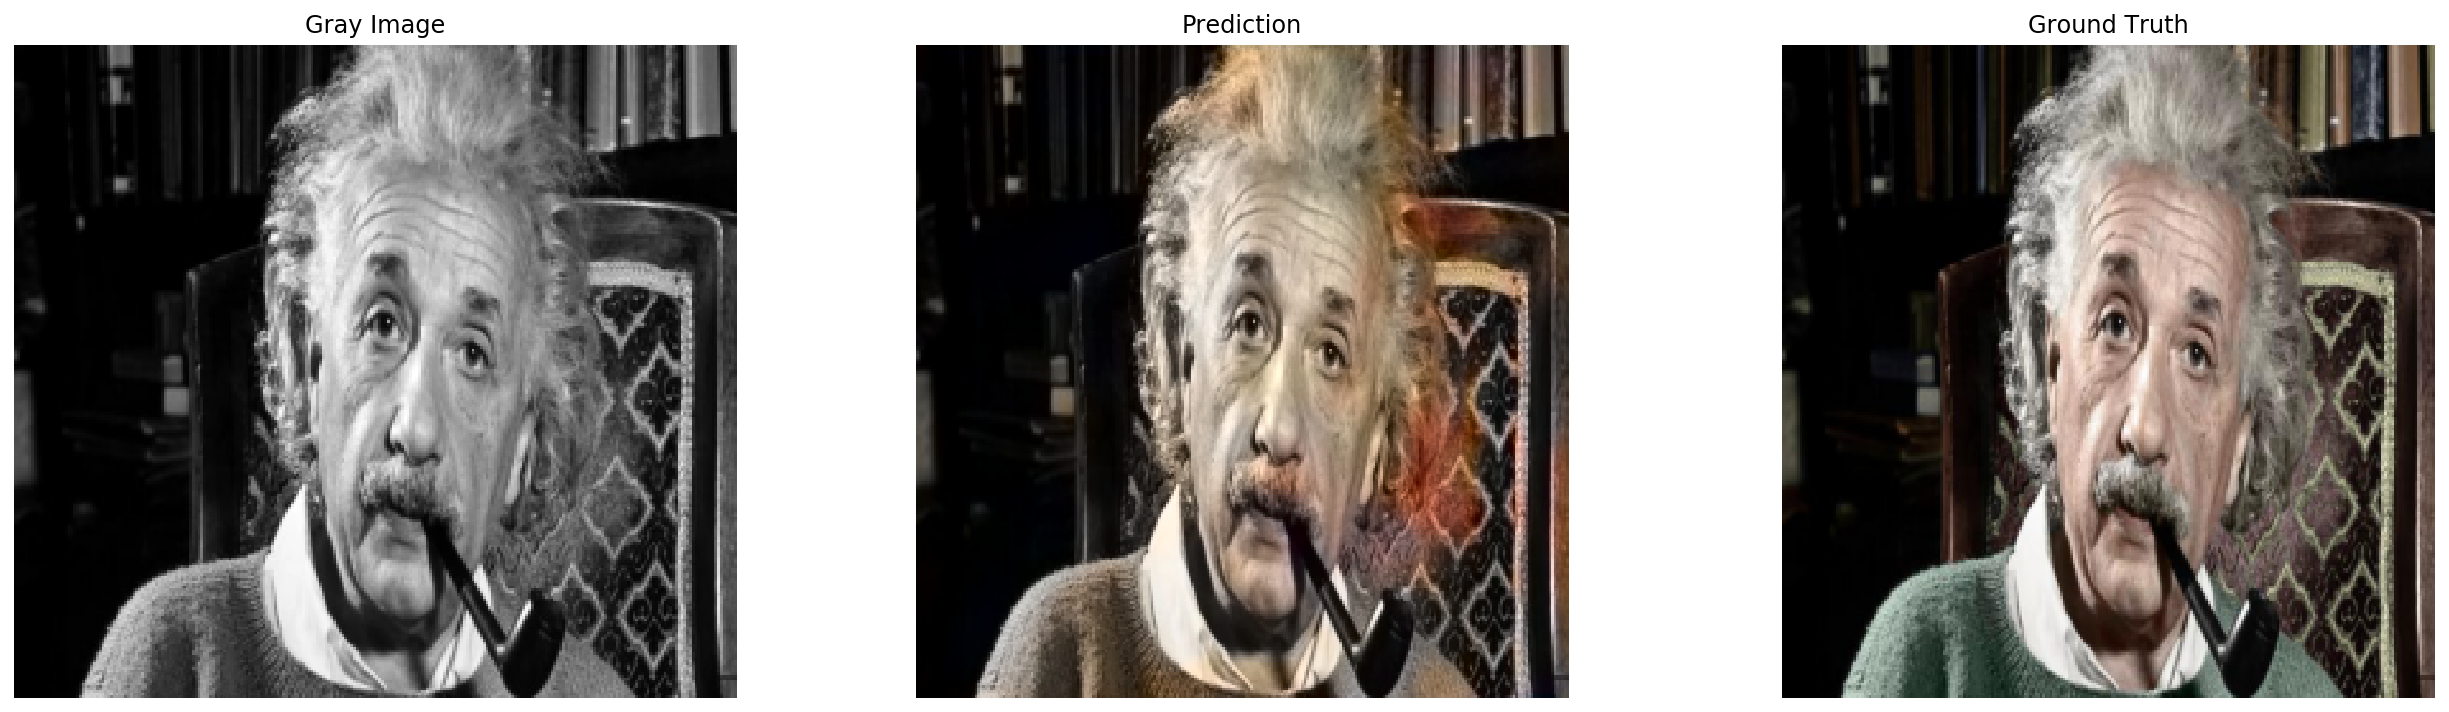

In [94]:
plt.figure(figsize=(22,6))

plt.subplot(1,3,1)
plt.imshow(rgb2gray(image)[0].reshape(256,256), interpolation="nearest", aspect="auto")
plt.gray()
plt.axis('off')
plt.title("Gray Image")

plt.subplot(1,3,2)
plt.imshow(decoded_images[0].reshape(256, 256,3))
plt.axis("off")
plt.title("Prediction")

plt.subplot(1,3,3)
plt.imshow(image.reshape(256, 256,3))
plt.axis("off")
plt.title("Ground Truth")